# Data distribution in the dataset

In [1]:
import matplotlib
from marss2l.utils import setup_stream_logger
import logging
from marss2l.utils import setup_stream_logger, get_remote_filesystem
import os
fs = get_remote_filesystem()

logger = logging.getLogger(__name__)
setup_stream_logger(logger)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

C0 = "#648FFF"
C1 = "#785EF0"
C2 = "#DC267F"
C3 = "#FE6100"
C4 = "#FFB000" # #FFB000

os.makedirs("figures", exist_ok=True)

Using account key


In [2]:
from marss2l import loaders

dataframe_data_traintest = loaders.read_csv(add_columns_for_analysis=True, fs=fs, split="all")

## Stats splits dataset

In [3]:
stats_time = dataframe_data_traintest.groupby("split_name")["tile_date"].agg(["count", "min", "max"]).rename(columns={"count": "nimages", "min": "min date", "max": "max date"})
stats_plumes = dataframe_data_traintest.groupby("split_name")["isplume"].sum()
stats_locs = dataframe_data_traintest.groupby("split_name")["location_name"].nunique()
stats_time["nplumes"] = stats_plumes
stats_time["nlocs"] = stats_locs

stats_time.loc[["train_2023", "val_2023", "test_2023"], ["nimages", "nplumes","nlocs", "min date", "max date"]].reset_index()


,split_name,nimages,nplumes,nlocs,min date,max date
0,train_2023,38366,3433,618,2018-01-01 09:13:51+00:00,2023-11-30 10:33:09+00:00
1,val_2023,6034,288,89,2021-01-01 07:03:09+00:00,2021-12-31 10:03:23.429000+00:00
2,test_2023,43529,1813,1289,2024-01-01 00:05:22.713000+00:00,2024-12-31 17:27:23.051000+00:00


## Figure wind speed 

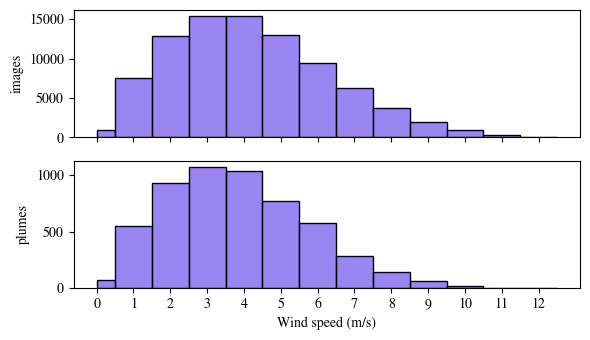

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dataframe_data_traintest_indexed = dataframe_data_traintest.set_index("id_loc_image")
valimages_df = dataframe_data_traintest_indexed.loc[dataframe_data_traintest_indexed.split_name.isin(["train_2023", "val_2023", "test_2023"])]

valplumes_df = valimages_df[valimages_df.isplume].copy()

fig, ax = plt.subplots(2,1,figsize=(6,3.5),sharex=True, tight_layout=True)

bins = [0,] + np.arange(0.5,valplumes_df.wind_speed.max()+.5,1).tolist()
bins_centers = np.arange(0,valplumes_df.wind_speed.max()+.5,1)
sns.histplot(x="wind_speed",data=valimages_df, bins=bins,color=C1,
            cumulative=False,common_norm=False,ax=ax[0])
sns.histplot(x="wind_speed",data=valimages_df[valimages_df.isplume], bins=bins,
             color=C1,
            cumulative=False,common_norm=False,ax=ax[1])
ax[1].set_xticks(bins_centers)
ax[1].set_ylabel("plumes")
ax[0].set_ylabel("images")
ax[1].set_xlabel("Wind speed (m/s)")
fig.savefig("figures/stats_by_wind.pdf")

## Figure area of the plume

In [5]:
from shapely import from_wkt
import geopandas as gpd
import rasterio.warp
from georeader import get_utm_epsg
from shapely.geometry import shape

dataframe_data_traintest_indexed = gpd.GeoDataFrame(dataframe_data_traintest_indexed, geometry=dataframe_data_traintest_indexed["plume"].apply(lambda x: from_wkt(x)),
                                                    crs="EPSG:4326")

def compute_area(geometry, crs_geometry:str="EPSG:4326") -> float:
    """
    Compute the area of a geometry in square meters by projecting it to UTM.

    Args:
        geometry (Geometry): geometry to compute the area
        crs_geometry (_type_, optional): CRS of the geometry. Defaults to "EPSG:4326".

    Returns:
        float: area of the geometry in square meters
    """
    center = geometry.centroid
    utm_crs = get_utm_epsg(center)
    geometry_utm = shape(rasterio.warp.transform_geom(crs_geometry, 
                                                      utm_crs, geometry))
    return geometry_utm.area


dataframe_data_traintest_indexed["area_meters"] = 0
plumes_good_index = dataframe_data_traintest_indexed.isplume & ~dataframe_data_traintest_indexed["geometry"].is_empty
dataframe_data_traintest_indexed.loc[plumes_good_index, "area_meters"] = dataframe_data_traintest_indexed.loc[plumes_good_index, "geometry"].apply(lambda x: compute_area(x))
dataframe_data_traintest_indexed["area_km"] = dataframe_data_traintest_indexed["area_meters"] / (1000**2)
valimages_df = dataframe_data_traintest_indexed.loc[dataframe_data_traintest_indexed.split_name.isin(["train_2023", "val_2023", "test_2023"])]
valplumes_df = valimages_df[valimages_df.isplume].copy()

/tmp/ipykernel_224426/4288469382.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 88661.64262182 119200.62052721 204363.39520962 ... 116100.00000028
  21645.35776812  28835.85959053]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe_data_traintest_indexed.loc[plumes_good_index, "area_meters"] = dataframe_data_traintest_indexed.loc[plumes_good_index, "geometry"].apply(lambda x: compute_area(x))


<Axes: xlabel='area_meters', ylabel='Count'>

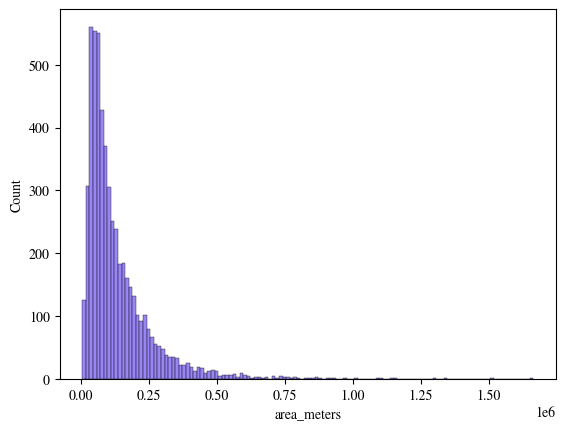

In [6]:
sns.histplot(x="area_meters",data=valplumes_df,color=C1,
            cumulative=False,common_norm=False)

/tmp/ipykernel_224426/1612739842.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


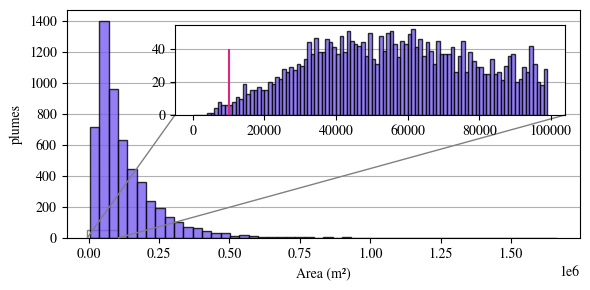

In [7]:
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

threshold_pixels = 100 * 10**2
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(valplumes_df["area_meters"], 
        bins=50,
         # bins=list(range(0,10_000,500))+list(range(10_000,100_000,5_000)),
         zorder=2, alpha=0.8, linewidth=1, edgecolor="black",color=C1)
# ax.set_xticks(np.arange(0,100_000,4000), [f"{l:.0f}"for l in np.arange(0,100_000,4000)/1000])
ax.set_xlabel("Area (m²)")
ax.set_ylabel("plumes")
ax.grid(axis="y")

# axins = zoomed_inset_axes(ax, 3, loc=1) # zoom = 6
axins = plt.axes([.3, .6, .65, .3])
axins.hist(valplumes_df["area_meters"], 
         # bins=list(range(0,10_000,500))+list(range(10_000,100_000,5_000)),
         bins=list(range(0,1000*10**2,10**3)),
         zorder=2, alpha=0.8, linewidth=1, edgecolor="black",color=C1)
axins.vlines(x=threshold_pixels, ymin=0, ymax=40, colors=C2)
# axins.set_xticks(np.arange(0,8_500,500), [f"{l:.1f}" if f"{l:.1f}"[-1] == "5" else f"{l:.0f}" for l in np.arange(0,8_500,500)/1000])
# axins.set_yticks(range(0,400, 100))
# axins.set_xlabel("Flux rate (t/h)")
# axins.set_ylabel("# plumes")
axins.grid(axis="y")

mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

fig.tight_layout()
fig.savefig("figures/areaplume.pdf")

In [8]:
nplumes_smaller = (valplumes_df.area_meters < threshold_pixels).sum()
print(f"There are {nplumes_smaller} of {valplumes_df.shape[0]} plumes with less than {threshold_pixels} m². {nplumes_smaller/valplumes_df.shape[0] * 100:.2f}%")

There are 26 of 5534 plumes with less than 10000 m². 0.47%


In [9]:
# With threshold 100 instead of 150
threshold = 50 *10**2
nplumes_smaller = (valplumes_df.area_meters < threshold).sum()
print(f"There are {nplumes_smaller} of {valplumes_df.shape[0]} plumes with less than {threshold} m². {nplumes_smaller/valplumes_df.shape[0] * 100:.2f}%")

There are 1 of 5534 plumes with less than 5000 m². 0.02%
